In [53]:
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

# Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})

resolution = '12km'
years= range(1990,2015)

##################################################################
# Loop through the years
##################################################################
year=2013

# Create directory to store outputs in
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/"
else:
    ddir = f"ProcessedData/TimeSeries/CEH-GEAR/{resolution}/NearestNeighbour/"
if not os.path.isdir(ddir):
    os.makedirs(ddir)

filenames =[]
# Create filepath to correct folder using correct resolution
if resolution == '1km': 
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_CEH-GEAR-1hr_{year}*'   
elif resolution == '2.2km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
elif resolution == '12km':
    general_filename = f'datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_{year}*'
print(general_filename)

# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    filenames.append(filename)
print(len(filenames))

monthly_cubes_list = iris.load(filenames, in_jja)    
#print(monthly_cubes_list)

# Concatenate the cubes into one
print('Concatenating cube')
obs_cube = monthly_cubes_list.concatenate_cube()     
print(obs_cube.shape) 

########################################################################
########################################################################
# ### Get the mask
########################################################################
########################################################################
print("getting mask")
if resolution =='2.2km':
    obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
elif resolution == '1km':
    obs_cube = trim_to_bbox_of_region_regriddedobs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_1km_GB_Mask.npy")
else:
    obs_cube = trim_to_bbox_of_region_obs(obs_cube, gb_gdf)
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
masked_cube_data = obs_cube * gb_mask[np.newaxis, :, :]


print(obs_cube.shape) 

# APPLY THE MASK
reshaped_mask = np.tile(gb_mask, (obs_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

# Mask the cube
masked_cube = iris.util.mask_cube(obs_cube, reversed_array)


datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_CEH-GEAR-1hr_2013*
12
Concatenating cube
(2208, 112, 82)
getting mask
(2208, 103, 74)


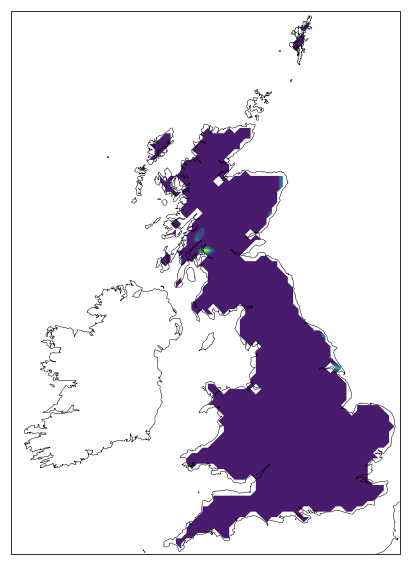

In [54]:
# Check the plotting
fig,ax = plt.subplots(figsize=(12,10))
iplt.contourf(masked_cube[100])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);
fig.savefig("Scripts/UKCP18_Validation/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/12km_map_CEH-GEAR.png",
           bbox_inches = 'tight')

In [33]:
##################################################################
# This Script:
#    - 
#    -
#    -

##################################################################
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load 
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "2002_2020"
yrs= range(2002,2020)
resolution = '12km' #2.2km, 12km, 2.2km_regridded_12km

### Establish the ensemble members
ems = ['05']#'06', '07', '08', '09', '10', '11', '12', '13', '15']

em='05'
ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/{em}/"

print(em, resolution, trim_to_leeds)
yr= 2004
print(em, yr)

# ### Get a list of filenames for this ensemble member, for just JJA
if resolution == '2.2km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
elif resolution == '12km':
      general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
elif resolution == '2.2km_regridded_12km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_*'

filenames = []
for filename in sir_globington_the_file_gatherer.glob(general_filename):
    filenames.append(filename)
print(f"loading {len(filenames)} files")

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)
print(len(monthly_cubes_list))

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]

# ### Concatenate cubes into one
model_cube = monthly_cubes_list.concatenate_cube()      

### Remove ensemble member dimension
model_cube = model_cube[0,:,:,:]

# # ### Trim to UK
# if resolution  == '2.2km':
#     model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)
# else:
#     model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf)

# # ### Get the mask
# print("getting mask")
# if resolution =='2.2km':
#     gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
# else:
#     gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
# masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

# # APPLY THE MASK
# reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
# reshaped_mask = reshaped_mask.astype(int)
# reversed_array = ~reshaped_mask.astype(bool)

# # Mask the cube
# masked_cube = iris.util.mask_cube(model_cube, reversed_array)

# # ### Check the mask
# # iplt.contourf(masked_cube[10])
# # plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

# # Save
# # iris.save(masked_cube, ddir + f'{yr}_maskedcube.nc')      

# Check the plotting
iplt.contourf(masked_cube[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);



KeyboardInterrupt: 

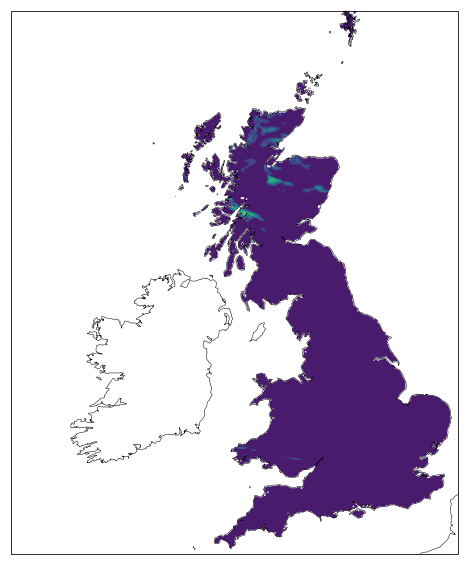

In [17]:
# Check the plotting
fig,ax = plt.subplots(figsize=(12,10))
iplt.contourf(masked_cube[100])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);
fig.savefig("Scripts/UKCP18_Validation/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/2.2km_map_UKCP18.png")

In [41]:
##################################################################
# This Script:
#    - Gets all 30 mins radar files for one year
#    - Joins them and masks out values over the sea
#    - Gets a 1D array of the data and removes masked out (over the sea
#      values) and np.nan values
##################################################################


##################################################################
# SET UP ENVIRONMENT
##################################################################
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from iris.experimental.equalise_cubes import equalise_attributes

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '12km'
trim_to_leeds = False

# # Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})

##################################################################
# FOR ONE YEAR AT A TIME
##################################################################
year=2010
print(year)

# Create directory to store outputs in and get general filename to load files from
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
    general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
elif resolution == '2.2km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/*'      
elif resolution == '12km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/*'      
if not os.path.isdir(ddir):
    os.makedirs(ddir)

# GET LIST OF ALL FILENAMES FOR THIS YEAR
filenames =[]
# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    # print(filename)
    filenames.append(filename)
print(f"loading {len(filenames)} filenames")
sorted_list = sorted(filenames)

# LOAD THE DATA
monthly_cubes_list = iris.load(sorted_list, in_jja)

##################################################################
# CLEAN AND JOIN THE DATA
##################################################################
# Get rid of any files which don't have the time dimension
is_to_delete = []
for i in range(0,len(monthly_cubes_list) ):
    if len(monthly_cubes_list[i].shape) <3:
        is_to_delete.append(i)
for i in is_to_delete:
    print(f"deleting cube {i} as it only had one dimension")
    del monthly_cubes_list[i] 

for i in range(0, len(monthly_cubes_list)):
    try:
        monthly_cubes_list[i].coord('forecast_period')
        monthly_cubes_list[i].remove_coord('forecast_period')
    except:
        pass
    try:
        monthly_cubes_list[i].coord('forecast_reference_time')
        monthly_cubes_list[i].remove_coord('forecast_reference_time')
    except:
        pass           
    try:
        monthly_cubes_list[i].coord('hour')
        monthly_cubes_list[i].remove_coord('hour')
    except:
        pass   

# Try to make attributes the same
iris.util.equalise_attributes(monthly_cubes_list)   

# CONVERT TO FLOAT64
for i in range(0, len(monthly_cubes_list)):
    monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')

model_cube = monthly_cubes_list.concatenate_cube()

# ### Trim to GB
if resolution  == '2.2km':
    model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)
else:
    model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf)

print(model_cube.coord('time')[0])
print(model_cube.coord('time')[-1])

# ### Get the mask
print("getting mask")
if resolution =='2.2km':
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
else:
    gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

# APPLY THE MASK
reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

# Mask the cube
masked_cube = iris.util.mask_cube(model_cube, reversed_array)


2010
loading 92 filenames
DimCoord([2010-06-01 00:12:30], bounds=[[2010-06-01 00:00:00, 2010-06-01 00:25:00]], standard_name='time', calendar='gregorian', var_name='time')
DimCoord([2010-08-31 23:42:30], bounds=[[2010-08-31 23:30:00, 2010-08-31 23:55:00]], standard_name='time', calendar='gregorian', var_name='time')
getting mask


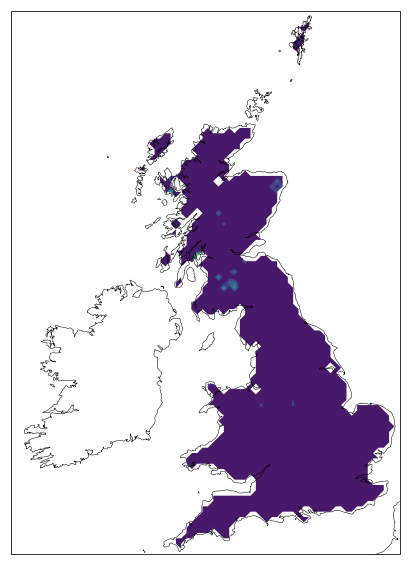

In [42]:
# Check the plotting
fig,ax = plt.subplots(figsize=(12,10))
iplt.contourf(masked_cube[150])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);
fig.savefig("Scripts/UKCP18_Validation/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/12km_map_NIMROD.png",
           bbox_inches="tight")